In [1]:
from astropy.table import Table
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from minisom import MiniSom
import pickle
import os

In [ ]:
points = [i / 10 for i in range(1, 20)] + [i for i in range(2, 10)]
a = []
for i in points:
    for j in points:
        b = {}
        b["dim"] = 30
        b["rate"] = i
        b["sigma"] = j
        a.append(b)

# with open("D:/SPHEREx_SOM/record/grid_search/both/normalization_per_source.pkl", 'wb') as handle:
#     pickle.dump(a, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [2]:
df_L3_info = Table.read('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_info.fits')
df_L3_info = df_L3_info.to_pandas()

In [3]:
L3_phot_data = np.loadtxt('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_averaged_phot102.txt')
phot_data = L3_phot_data[:,3::2]
phot_err_data = L3_phot_data[:,4::2]

In [4]:
def remove_low_SNR(data, data_err, info_data, mode, mag_cut):
    i_band = info_data["HSC_i_MAG"].values
    if mode == "mag_cut" or mode == "both":
        if type(mag_cut) == type(1):
            max_cut = np.mean(i_band) - np.std(i_band, ddof = 1) * mag_out
            data = data[i_band < max_cut]
            data_err = data[i_band < max_cut]
            info_data = info_data[np.logical_and((i_band < mag_cut[1]), (i_band > mag_cut[0]))]
        else:
            data = data[np.logical_and((i_band < mag_cut[1]), (i_band > mag_cut[0]))]
            data_err = data_err[np.logical_and((i_band < mag_cut[1]), (i_band > mag_cut[0]))]
            info_data = info_data[np.logical_and((i_band < mag_cut[1]), (i_band > mag_cut[0]))]
    if mode == "band_cut" or mode == "both":
        data = data[:, : len(data[0]) - 34]
        data_err = data_err[:, : len(data_err[0]) - 34]
        
    return data, data_err, info_data

In [5]:
def grid_search(data, err, file):
    n = 0
    with open(file, "rb") as fh:
        record = pickle.load(fh)
    if "som" not in record[-1]:
        for i in record:
            n += 1
            if "som" not in i:
                som = MiniSom(i["dim"], i["dim"], data.shape[1], sigma = i["sigma"], learning_rate = i["rate"])
                som.random_weights_init(data)
                som.train(data, err, num_iteration = 1, use_epochs = True) 
                i["topo_err"] = som.topographic_error(data)
                i["quan_err"] = som.quantization_error(data)
                i["som"] = som
                i["band_cut"] = len(data[0])
                i["mag_cut"] = len(data)
                i["preproc"] = "default"
                i["topo_err"] = som.topographic_error(data)
                i["quan_err"] = som.quantization_error(data)
                print(f"File: {file}, progress: {round(n / len(record) * 100, 2)}%, param: {[i["dim"], i["sigma"], i["rate"]]}", end = "\r")
                try:
                    with open(file, 'wb') as handle:
                        pickle.dump(record, handle, protocol=pickle.HIGHEST_PROTOCOL)
                except KeyboardInterrupt:
                    print('KeyboardInterrupt caught, data saved.')
    else:
        pass

In [6]:
def visual_map(file, dim, sigma, rate, data, err, info_data, save = False):
    with open(file, "rb") as fh:
        record = pickle.load(fh)
    for k in record:
        if k["dim"] == dim and k["rate"] == rate and k["sigma"] == sigma:
            pass
        else:
            continue
        som = k["som"]
        print(f"Topological error: {som.topographic_error(data)}")
        print(f"Quantization error: {som.quantization_error(data)}")
        if "density" in k:
            density_map = k["density"]
            magnitude_map = k["magnitude"]
            z_map = k["z"]
            
            %matplotlib inline
            plt.close()
            plt.figure(figsize = (30, 20))
            plt.subplot(221)
            plt.pcolor(som.distance_map().T, cmap='YlGn')  # plotting the distance map as background
            plt.colorbar()
            plt.title("Distance map (U-matrix)")
        
            plt.subplot(222)
            plt.pcolor(density_map.T, cmap='YlGn')
            plt.colorbar()
            plt.title("Density Map")
        
            plt.subplot(223)
            plt.pcolor(magnitude_map.T, cmap="plasma" + "_r")
            plt.colorbar()
            plt.title("HSC I Magnitude Map")
        
            plt.subplot(224)
            plt.pcolor(z_map.T, cmap="plasma")
            plt.colorbar()
            plt.title("True Redshift Map")
            if save != False:
                plt.savefig(save + f"{dim}_{sigma}_{rate}.jpg", bbox_inches = "tight")
            
            plt.show()
            continue
        else:
            pass
        
        density_map = np.zeros(dim ** 2).reshape(dim, dim)
        magnitude_map = np.zeros(dim ** 2).reshape(dim, dim)
        magnitude_map.fill(np.nan)
        z_map = np.zeros(dim ** 2).reshape(dim, dim)
        z_map.fill(np.nan)
        
        labels_map_1 = som.labels_map(data, err, [0] * len(data))
        labels_map_2 = som.labels_map(data, err, tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), np.expand_dims(info_data["z_true"].values, axis = 1)), axis = -1))))
    
        for i in labels_map_1.keys():
            density_map[int(list(i)[0]), int(list(i)[1])] = labels_map_1[i][0]
        
        for i in labels_map_2.keys():
            properties = np.mean(np.array(list(labels_map_2[i].keys())), axis = 0)
            magnitude_map[int(list(i)[0]), int(list(i)[1])] = properties[0]
            z_map[int(list(i)[0]), int(list(i)[1])] = properties[1]

        %matplotlib inline
        plt.close()
        plt.figure(figsize = (30, 20))
        plt.subplot(221)
        plt.pcolor(som.distance_map().T, cmap='YlGn')  # plotting the distance map as background
        plt.colorbar()
        plt.title("Distance map (U-matrix)")
        
        plt.subplot(222)
        plt.pcolor(density_map.T, cmap='YlGn')
        plt.colorbar()
        plt.title("Density Map")
    
        plt.subplot(223)
        plt.pcolor(magnitude_map.T, cmap="plasma" + "_r")
        plt.colorbar()
        plt.title("HSC I Magnitude Map")
    
        plt.subplot(224)
        plt.pcolor(z_map.T, cmap="plasma")
        plt.colorbar()
        plt.title("True Redshift Map")
        if save != False:
            plt.savefig(save + f"{dim}_{sigma}_{rate}.jpg", bbox_inches = "tight")
        
        plt.show()
    
        k["density"] = density_map
        k["magnitude"] = magnitude_map
        k["z"] = z_map

        try:
            with open(file, 'wb') as handle:
                pickle.dump(record, handle, protocol=pickle.HIGHEST_PROTOCOL)
        except KeyboardInterrupt:
            print('KeyboardInterrupt caught, data saved.')

In [7]:
def parameter_space(save, file):
    tick_f = [i / 10 for i in range(1, 20)] + [i for i in range(2, 10)]
    tick_i = [i + 0.5 for i in range(0, len(tick_f))]
    
    quan_map30 = np.zeros((len(tick_f), len(tick_f)))
    topo_map30 = np.zeros((len(tick_f), len(tick_f)))
    quan_map50 = np.zeros((len(tick_f), len(tick_f)))
    topo_map50 = np.zeros((len(tick_f), len(tick_f)))
    quan_map70 = np.zeros((len(tick_f), len(tick_f)))
    topo_map70 = np.zeros((len(tick_f), len(tick_f)))
    quan_map90 = np.zeros((len(tick_f), len(tick_f)))
    topo_map90 = np.zeros((len(tick_f), len(tick_f)))

    index = dict(zip(tick_f, [i - 0.5 for i in tick_i]))
    
    with open(file, "rb") as fh:
        record = pickle.load(fh)
        
    for i in record:
        if i["dim"] == 30:
            topo_map30[int(index[i["sigma"]]), int(index[i["rate"]])] = i["topo_err"]
            quan_map30[int(index[i["sigma"]]), int(index[i["rate"]])] = i["quan_err"]

        elif i["dim"] == 50:
            topo_map50[int(index[i["sigma"]]), int(index[i["rate"]])] = i["topo_err"]
            quan_map50[int(index[i["sigma"]]), int(index[i["rate"]])] = i["quan_err"]

        elif i["dim"] == 70:
            topo_map70[int(index[i["sigma"]]), int(index[i["rate"]])] = i["topo_err"]
            quan_map70[int(index[i["sigma"]]), int(index[i["rate"]])] = i["quan_err"]

        elif i["dim"] == 90:
            topo_map90[int(index[i["sigma"]]), int(index[i["rate"]])] = i["topo_err"]
            quan_map90[int(index[i["sigma"]]), int(index[i["rate"]])] = i["quan_err"]

    if np.sum(quan_map30) == 0:
        quan_map30 = np.ones((len(tick_f), len(tick_f)))
    if np.sum(quan_map50) == 0:
        quan_map50 = np.ones((len(tick_f), len(tick_f)))
    if np.sum(quan_map70) == 0:
        quan_map70 = np.ones((len(tick_f), len(tick_f)))
    if np.sum(quan_map90) == 0:
        quan_map90 = np.ones((len(tick_f), len(tick_f)))
        
    topo_maps = [topo_map30, topo_map50, topo_map70, topo_map90]
    quan_maps = [quan_map30, quan_map50, quan_map70, quan_map90]
    
    plt.close()
    plt.figure(figsize = (30, 20))

    for i in range(1, 5):
        dim = (i * 2 + 1) * 10
        plt.subplot(220 + i)
        plt.hist(topo_maps[i - 1].reshape(-1), bins = 20)
        plt.xlabel("Topological Error", fontsize=20)
        plt.ylabel("# of Glaxies", fontsize=20)
    
    if save:
        plt.savefig(save + "topo_err_dist.jpg", bbox_inches = "tight")    
    plt.show()

    plt.close()
    plt.figure(figsize = (30, 20))
    for i in range(1, 5):
        dim = (i * 2 + 1) * 10
        plt.subplot(220 + i)
        plt.hist(np.log10(quan_maps[i - 1]).reshape(-1), bins = 20)
        plt.xlabel("log(Quantization Error)", fontsize=20)
        plt.ylabel("# of Glaxies", fontsize=20)
        plt.yscale("log")
        
    if save:
        plt.savefig(save + "quan_err_dist.jpg", bbox_inches = "tight")  
    plt.show()
    
    plt.close()
    plt.figure(figsize = (30, 20))
    for i in range(1, 5):
        dim = (i * 2 + 1) * 10
        plt.subplot(220 + i)
        plt.pcolor(topo_maps[i - 1], cmap = 'YlGn')
        plt.title(f"Topological Error (Dim: {dim}X{dim} / Cut: both)", fontsize=20)
        plt.xlabel("Rate", fontsize=15)
        plt.ylabel("Sigma", fontsize=15)
        plt.xticks(tick_i, tick_f, fontsize=10)
        plt.yticks(tick_i, tick_f, fontsize=10)
        plt.colorbar().ax.tick_params(labelsize=15)

    if save:
        plt.savefig(save + "topo_err_para_space.jpg", bbox_inches = "tight")  
    plt.show()
    
    plt.close()
    plt.figure(figsize = (30, 20))
    for i in range(1, 5):
        dim = (i * 2 + 1) * 10
        plt.subplot(220 + i)
        plt.pcolor(np.log10(quan_maps[i - 1]), cmap = 'YlGn')
        plt.title(f"Quantizationl Error (Dim: {dim}X{dim} / Cut: both)", fontsize=20)
        plt.xlabel("Rate", fontsize=15)
        plt.ylabel("Sigma", fontsize=15)
        plt.xticks(tick_i, tick_f, fontsize=10)
        plt.yticks(tick_i, tick_f, fontsize=10)
        plt.colorbar().ax.tick_params(labelsize=15)

    if save != False:
        plt.savefig(save + "quan_err_para_space.jpg", bbox_inches = "tight")  
    plt.show()

In [8]:
data, data_err, info_data = remove_low_SNR(data = phot_data, data_err = phot_err_data, info_data = df_L3_info, mode = "both", mag_cut = [0, 22])
data = (data - np.mean(data, axis = 0, keepdims = True)) / np.std(data, axis = 0, keepdims = True)
data.shape

(13651, 68)

In [ ]:
for j in os.listdir("D:/SPHEREx_SOM/record/grid_search/both/"):
    if "check" in j or "diagram" in j:
        continue
    file = "D:/SPHEREx_SOM/record/grid_search/both/" + j
    grid_search(data = data, err = phot_err_data, file = file)

In [ ]:
grid_search(data = data, err = data_err, file = "D:/SPHEREx_SOM/record/grid_search/both/normalization_per_source.pkl")

In [ ]:
parameter_space(save = "D:/SPHEREx_SOM/record/grid_search/both/diagram+normalization_per_source/", file = "D:/SPHEREx_SOM/record/grid_search/both/normalization_per_source.pkl")

In [ ]:
for i in range(1, 21):
    visual_map(file = "D:/SPHEREx_SOM/record/grid_search/both/normalization_per_source.pkl", dim = 30, sigma = i / 10, rate = 1.2, data = data, err = data_err, info_data = info_data, save = "D:/SPHEREx_SOM/record/grid_search/both/diagram+normalization_per_source/")
print("finish")

Topological error: 0.029008863819500404
Quantization error: 3.1284602776625947


C:\Users\ASUS\AppData\Local\Temp\ipykernel_72864\760519119.py:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_72864\760519119.py:37: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


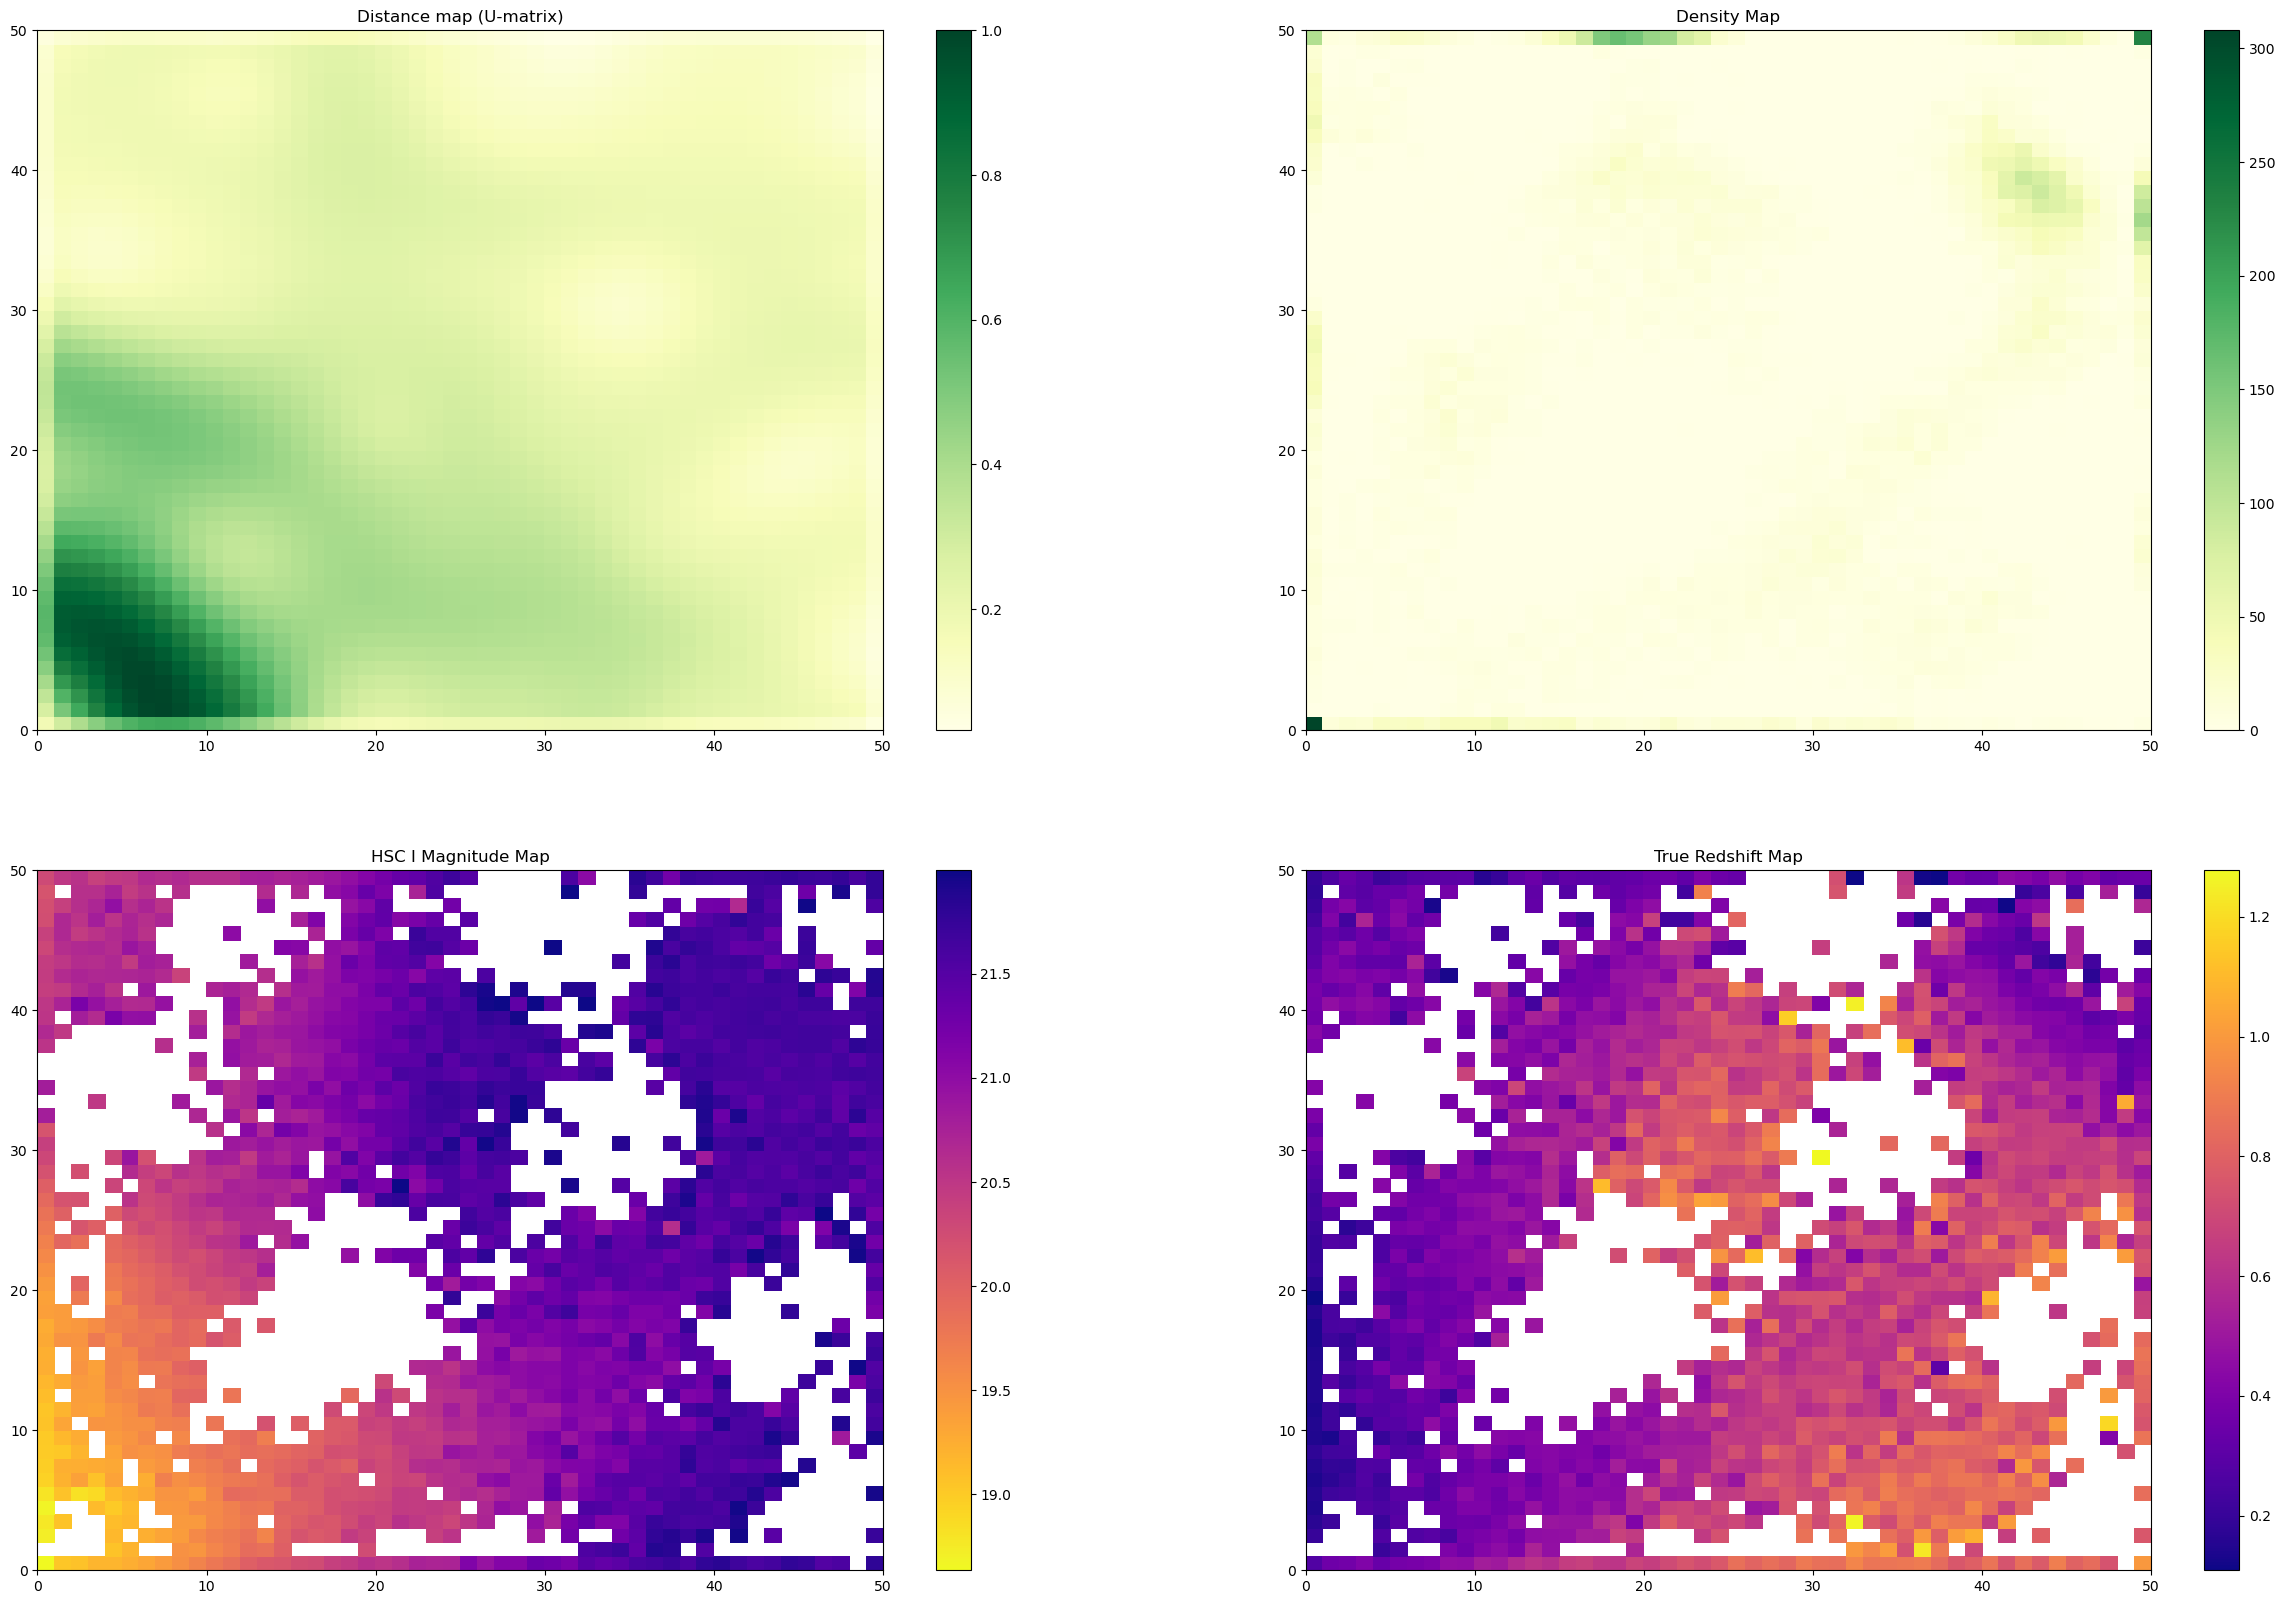

In [9]:
visual_map(file = "D:/SPHEREx_SOM/record/grid_search/both/high_sigma_low_rate.pkl", dim = 50, sigma = 7, rate = 0.6, data = data, err = data_err, info_data = info_data, save = False)